## PINNs solution of Hydrodynamical Equations (NO-GRAVITY) in 2D and compare with Finite Difference Solution

Author :  Sayantan Auddy 

Date   :  13 March 2023

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import os

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
import scipy
# plt.style.use('ggplot')
## Setting the backend to Tensorflow
dde_backend = tf

## For the FFT solver

from numpy.fft import fft, ifft
from scipy import signal

np.random.seed(1234)
tf.random.set_seed(1234)

Using backend: tensorflow.compat.v1



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


2023-04-07 14:31:51.611022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 14:31:55.301229: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 14:32:03.990433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-07 14:32:03.992016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




### 1.1 Equations

The hydrostatic system with self-gravity-- 

For an isothermal gas, the dynamics is governed by continuity equation and the momentum equation. They are given as follows,

The mass-continuity equation
$$
\begin{equation}\label{continuity}
    \frac{\partial \rho}{\partial t} + \nabla.(\rho \vec v) =0
\end{equation}\tag{1}
$$
The momentum equation 
$$
\begin{eqnarray}
\rho \frac{d \vec v}{ d t} = - \nabla P + %\rho \vec g \\
\rho \left[\frac{\partial v}{\partial t}+ (\vec v . \nabla)\vec v \right] = - \nabla P %+ \rho \vec g
\end{eqnarray}\tag{3}
$$
% The self-gravity is 
% $$
% \begin{equation}
% \nabla. \vec g = -4\pi G\rho
% \end{equation}\tag{3}
% $$

% where
% $$
% \begin{equation}\label{poisson}
% \nabla^2 \phi =  4 \pi G \rho
% \end{equation}\tag{4}
% $$
% is Poisson's equation and  

% $$
% \begin{equation}
% \nabla \phi =  - \vec g 
% \end{equation}\tag{5}
% $$
<!-- 
For simplicity, we consider only 1-D. Later we implement 2D and 3D using PINNS.
$$
\begin{eqnarray}
    \frac{\partial \rho_1}{\partial t} + \rho_0 \frac{\partial v_1} {\partial x}  = 0 \\
    \rho_0 \frac{\partial v_1}{\partial t} = - c_s^{2} \frac{\partial \rho_1}{\partial x}  + \rho g_{1} \\
    % P_{1} = \gamma \frac{P_{0}}{\rho_0} \rho_1\\
    \frac{\partial g_1}{\partial x} = - 4 \pi G \rho_1
\end{eqnarray}\tag{6}
$$ -->

#### The initial conditions is derivered using linear analysis (refer to the paper)

$$
\begin{eqnarray}
\rho(x,t=0) &=& \rho_{0} + \rho_{1}\cos\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{7}
$$

When self-gravity is active and $\lambda> \lambda_{J}$ 

$$
\begin{eqnarray}
v_{x}(x,t=0) &=& -v_{1} \sin\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{8}
$$

where $v_1 = \frac{\alpha}{k} \frac{\rho_1}{\rho}$ and 
$$
\begin{eqnarray}
    \alpha = \sqrt{ 4 \pi G \rho_0 - c_s^2 k^2}
\end{eqnarray}\tag{9}
$$
however for $\lambda < \lambda_{J}$  and for non self-gravitating system 

$$
\begin{eqnarray}
v_{x}(x) &=& v_{1} \cos\left(2\pi x/\lambda\right)
\end{eqnarray}\tag{10}
$$

#### Considering Periodic Boundary Conditions


$$
\begin{eqnarray}
\rho(x=0,t) &=& \rho (x=xmax,t)\\
v_{x}(x=t,t) &=& v_{x}(x=xmax,t)
\end{eqnarray}\tag{11}
$$


### 1.2 Methodology : Using PINNs

The method constructs a neural network approximation. We consider a single neural network with the desired output varibles, $\rho$, $\vec vx$ , $\vec vy$ and $\phi $ - 

$$
\begin{aligned}
\vec vy_\theta(t,x,y), \vec vx_\theta(t,x,y), \rho_\theta(t,x,y) &\approx \mathcal N_{\rho, v}(X;\theta) \\
% \vec v_\theta(t,x) &\approx \mathcal N_{v}(X;\theta_{v})
\end{aligned}\tag{12}
$$

where $X:= (x,y,t)$, $\theta$ are the parameters for the networks. 

<!-- The idea is to first optimize the network parameters of $\mathcal N_{\rho}(X;\theta_{\rho})$ with those of $\mathcal N_{v}(X;\theta_{v})$ fixed and then vice versa, and the process is iterated until convergennce is achieved. -->

In this approach the total loss can be decoupled as:

The PDE losses associated with Eqs
$$
\begin{eqnarray}
\mathcal L_{\rho} =  \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\partial_t \rho_{\theta}\left(t_i^r, x_i^r,y_i^r\right)+ \partial_x (\rho_{\theta}\left(t_i^r, x_i^r,y_i^r\right) \vec vx_{\theta}\left(t_i^r, x_i^r,y_i^r\right)) + \partial_y (\rho_{\theta}\left(t_i^r, x_i^r,y_i^r\right) \vec vy_{\theta}\left(t_i^r, x_i^r,y_i^r\right)) \right|^2 
\end{eqnarray}\tag{13}
$$

<!-- rho*vx_t + rho*(vx*vx_x +vy*vx_y) + cs*cs*rho_x +rho*phi_x -->
<!-- $$
\begin{eqnarray}
\mathcal L_{\vec vx} =  \frac{1}{N_r}\sum_{i=1}^{N_r}\left|\partial_t \left[\rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right)\vec vx_{\theta} \left(t_i^r, x_i^r,y_i^r\right)\right] + \partial_x \left[\rho_{\theta} \left[ \left(t_i^r, x_i^r,y_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r,y_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r,y_i^r\right) +\left(t_i^r, x_i^r,y_i^r\right)\vec vy_{\theta} \left(t_i^r, x_i^r,y_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r,y_i^r\right)\right] \right]+ c_s^2 \partial_x \rho_{\theta}\left(t_i^r, x_i^r,y_i^r\right)\right|^2
\end{eqnarray}\tag{14}
$$ -->

$$
\begin{eqnarray}
\mathcal L_{\vec vx} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \partial_t \vec vx_{\theta} \left(t_i^r, x_i^r,y_i^r\right)+ \rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \left[ \vec vx_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \partial_x \vec vx_{\theta} \left(t_i^r, x_i^r,y_i^r\right)+ \vec vy_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \partial_y \vec vx_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \right ]+ c_s^2 \partial_x \rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right)  \right |^2
\end{eqnarray}\tag{14}
$$


$$
\begin{eqnarray}
\mathcal L_{\vec vy} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \partial_t \vec vy_{\theta} \left(t_i^r, x_i^r,y_i^r\right)+ \rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \left[ \vec vy_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \partial_y \vec vy_{\theta} \left(t_i^r, x_i^r,y_i^r\right)+ \vec vx_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \partial_x \vec vy_{\theta} \left(t_i^r, x_i^r,y_i^r\right) \right ]+ c_s^2 \partial_y \rho_{\theta} \left(t_i^r, x_i^r,y_i^r\right)  \right |^2
\end{eqnarray}\tag{14}
$$

<!-- $$
\begin{eqnarray}
\mathcal L_{\vec \phi} = \frac{1}{N_r}\sum_{i=1}^{N_r} \left| \partial_{xx}\phi\left(t_i^r, x_i^r,y_i^r\right) +\partial_{yy}\phi\left(t_i^r, x_i^r,y_i^r\right)- const* \left(\rho_{\theta}\left(t_i^r, x_i^r,y_i^r\right) - \rho_o\right)   \right |^2
\end{eqnarray} 
$$ -->

where $n$ is the total number of collocation points in the domain denoted by $X$ in a number of collocation points $X^r:=\{(t_i^r, x_i^r),y_i^r\}_{i=1}^{N_r} $

The losses associated with initial and boundary conditions for density $\rho $


$$
    \begin{align*}
   \mathcal L_{\rho_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\rho_{\theta}\left(t_i^0, x_i^0,y_i^0\right) - \rho_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\rho_bx}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\rho_{\theta}\left(t_i^b, x_i^b, y_i^b\right) - \rho_{b}\left(t_i^b, x_i^b,y_i^b\right)\right|^2
    \end{align*}\tag{15}
$$




The losses associated with initial and boundary conditions for velocity $\vec vx_{\theta} $


$$
    \begin{align*}
   \mathcal L_{\vec v_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\vec v_{\theta}\left(t_i^0, x_i^0, y_i^0\right) - \vec v_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\vec  vx_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\vec v_{\theta}\left(t_i^b, x_i^b,y_i^b\right) - \vec v_{b}\left(t_i^b, x_i^b,y_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

<!-- in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\vec v_\theta$ is the neural network approximation of the solution $\vec v\colon[0,T] \times \mathcal{D} \to \mathbb{R}$. -->



<!-- The losses associated with  boundary conditions for potential $\phi_{\theta} $

$$
   \begin{align*}   
   \mathcal L_{\phi_0}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b}  \left|\phi_{\theta}\left(t_i^b, x_i^b,y_i^b\right) - \phi_{b}\left(t_i^b, x_i^b,y_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

$$
   \begin{align*}   
   \mathcal L_{d\phi_{bx}}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b}  \left|d\phi_{\theta}\left(t_i^b, x_i^b,y_i^b\right) - d\phi_{b}\left(t_i^b, x_i^b,y_i^b\right)\right|^2
    \end{align*}\tag{16}
$$
 -->
in a number of points $X^0:=\{(t^0_i,x^0_i,y^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i,y^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\rho_\theta$ is the neural network approximation of the solution $\rho\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.

#### Similar boudnaries are also applied in the y direction

In this sequential approach the total loss is decoupled as: 

$$
\begin{eqnarray}
\mathcal L_{\mathcal N_{\rho}} = \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_bx}+\mathcal L_{\rho_by}  \\ 
\mathcal L_{\mathcal N{\vec vx}} = \mathcal L_{\vec vx} + \mathcal L_{\vec vx_0} +\mathcal L_{\vec vx_bx} + \mathcal L_{\vec vx_by} \\\
\mathcal L_{\mathcal N{\vec vy}} = \mathcal L_{\vec vy} + \mathcal L_{\vec vy_0} +\mathcal L_{\vec vy_bx} + \mathcal L_{\vec vy_by} \\
% \mathcal L_{\mathcal N_{\phi}} =  \mathcal L_{\vec \phi} + \mathcal L_{\phi_bx} + \mathcal L_{\phi_by} + \mathcal L_{d\phi_0x} + \mathcal L_{d\phi_y}\\ 
\end{eqnarray}\tag{17}
$$

The TOTAL LOSS  

$$
\begin{eqnarray}
\mathcal L_{Total} = \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_bx}+\mathcal L_{\rho_by}  +\mathcal L_{\vec vx} + \mathcal L_{\vec vx_0} +\mathcal L_{\vec vx_bx} + L_{\vec vx_by}+ \mathcal L_{\vec vy} + \mathcal L_{\vec vy_0} +\mathcal L_{\vec vy_bx} + \mathcal L_{\vec vy_by} + \mathcal L_{\vec \phi} + %\mathcal L_{\phi_bx} + \mathcal L_{\phi_by} + \mathcal L_{d\phi_0x} + \mathcal L_{d\phi_y}
\end{eqnarray}

In [2]:
#Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
lam = 1.0           # one wavelength
num_of_waves = 2     # the number of waves
#%matplotlib inlinemaxT = 0.5           # maximum time (0.3,0.5,1 second)

rho_1 = 0.03;       # 0.03 linear and  0.3 non-linear wave propagation
rho_o = 1.0          # zeroth order density
cs = 1. ## Is the sound speed
v_1 = (cs*rho_1)/rho_o # velocity perturbation
tmax= 1

## For comparison

ycut=0.5

output_folder = "figures_waves-2D" 

try:
    os.makedirs(output_folder)
except OSError:
    print ("Creation of the directory %s failed/ not needed as it already exit" % output_folder)
else:
    print ("Successfully created the directory %s" % output_folder)


Successfully created the directory figures_waves-2D


### Network hyperparameters

In [3]:
## General Network Parameters

learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 32 ## 100
activation = "sin" #"tanh"

iterations_adam = 2000

# collocation_points 
precision_train = 100 #200 ## collocation points density
hx_train = lam/ precision_train
nx_train = int(1 / hx_train)*num_of_waves
print("The number of collocation points resolving the domain are = {} and at boundaries are = {}".format(nx_train*nx_train*tmax,50*nx_train))


The number of collocation points resolving the domain are = 40000 and at boundaries are = 10000


Compiling model...
Building feed-forward neural network...
'build' took 0.128847 s



/home/sauddy3/PINNS-envcedar/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-04-07 14:32:19.976329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 14:32:23.070551: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-04-07 14:32:23.073310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25989 MB memor

wavelength 1.0
wavelength 1.0
'compile' took 4.836002 s

Initializing variables...


2023-04-07 14:32:24.735299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Training model...



2023-04-07 14:32:25.518803: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2aeb6400e1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-07 14:32:25.518940: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-04-07 14:32:25.809805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-07 14:32:26.881231: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-07 14:32:29.810790: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.08e-01, 1.07e-02, 5.31e-02, 1.84e-02, 5.17e-02, 1.48e-03, 3.72e-03, 3.99e-02, 4.34e-02, 9.94e-01, 9.43e-04, 4.56e-02]    [1.08e-01, 1.07e-02, 5.31e-02, 1.84e-02, 5.17e-02, 1.48e-03, 3.72e-03, 3.99e-02, 4.34e-02, 9.94e-01, 9.43e-04, 4.56e-02]    []  
1000      [1.71e-05, 2.07e-05, 2.63e-05, 5.96e-06, 6.57e-06, 1.22e-06, 1.16e-06, 4.28e-06, 2.01e-05, 4.58e-04, 4.41e-04, 1.13e-05]    [1.71e-05, 2.07e-05, 2.63e-05, 5.96e-06, 6.57e-06, 1.22e-06, 1.16e-06, 4.28e-06, 2.01e-05, 4.58e-04, 4.41e-04, 1.13e-05]    []  
2000      [3.77e-06, 8.07e-06, 9.21e-06, 3.15e-06, 2.54e-06, 8.23e-07, 5.23e-07, 1.61e-06, 3.52e-06, 4.52e-04, 4.42e-04, 1.80e-06]    [3.77e-06, 8.07e-06, 9.21e-06, 3.15e-06, 2.54e-06, 8.23e-07, 5.23e-07,

2023-04-07 14:32:45.711639: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
2000      [3.77e-06, 8.07e-06, 9.21e-06, 3.15e-06, 2.54e-06, 8.23e-07, 5.23e-07, 1.61e-06, 3.52e-06, 4.52e-04, 4.42e-04, 1.80e-06]    [3.77e-06, 8.07e-06, 9.21e-06, 3.15e-06, 2.54e-06, 8.23e-07, 5.23e-07, 1.61e-06, 3.52e-06, 4.52e-04, 4.42e-04, 1.80e-06]    []  
3000      [6.16e-06, 4.14e-06, 6.30e-07, 6.50e-06, 1.30e-07, 5.83e-06, 8.72e-08, 3.87e-07, 2.51e-07, 4.21e-04, 4.17e-04, 2.48e-07]    [6.16e-06, 4.14e-06, 6.30e-07, 6.50e-06, 1.30e-07, 5.83e-06, 8.72e-08, 3.87e-07, 2.51e-07, 4.21e-04, 4.17e-04, 2.48e-07]        
4000      [1.76e-05, 3.52e-06, 3.13e-06, 3.10e-06, 8.35e-07, 2.89e-06, 7.47e-07, 2.87e-07, 3.31e-07, 9.96e-06, 1.02e-05, 3.79e-07]    [1.76e-05, 3.52e-06, 3.13e-06, 3.10e-06, 8.35e-07, 

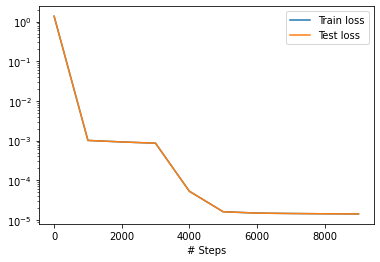

In [4]:
def pdeg(x, y):   

    '''
    The first argument to pde is a 2-dimensional vector where the first component(x[:,0]) is 𝑥
    -coordinate and the second componenet (x[:,1]) is the 𝑡-coordinate.

    The second argument is the network output,is 3-dimensional vector where the first component
    (y[:,0]) is density and the second componenet (y[:,1]) is the velocity amd the third component  (y[:,2])is 
    the gravity in the x direction
    '''
    cs = 1. ## Is the sound speed

    rho, vx, vy, phi= y[:,0:1],y[:,1:2],y[:,2:3],y[:,3:4] 
    
    rho_t = dde.grad.jacobian(y, x, i=0, j=2)
    rho_x = dde.grad.jacobian(y, x, i=0, j=0)
    rho_y = dde.grad.jacobian(y, x, i=0, j=1)


    vx_t = dde.grad.jacobian(y, x, i=1, j=2)
    vy_t = dde.grad.jacobian(y, x, i=2, j=2)
    vx_x = dde.grad.jacobian(y, x, i=1, j=0)
    vy_y = dde.grad.jacobian(y, x, i=2, j=1)
    
    vx_y = dde.grad.jacobian(y, x, i=1, j=1)
    vy_x = dde.grad.jacobian(y, x, i=2, j=0)
   
#     phi_x = dde.grad.jacobian(y, x, i=3, j=0)
#     phi_xx= dde.grad.hessian(y, x, component=3, i=0, j=0)
    
#     phi_y = dde.grad.jacobian(y, x, i=3, j=1)
#     phi_yy= dde.grad.hessian(y, x, component=3, i=1, j=1)
    

    
    rho_r = rho_t + vx * rho_x + rho * vx_x + vy *rho_y + rho * vy_y  ## The residue from the density equation

    # vx_r = rho*vx_t + rho*vx*vx_x + cs*cs*rho_x +rho*phi_x  ### THe momentum equation in 1D- in X
    # vy_r = rho*vy_t + rho*vy*vy_y + cs*cs*rho_y +rho*phi_y  ### THe momentum equation in 1D- in Y
#     
    vx_r = rho*vx_t + rho*(vx*vx_x +vy*vx_y) + cs*cs*rho_x # +rho*phi_x  ### THe momentum equation in 1D- in X
    vy_r = rho*vy_t + rho*(vy*vy_y+ vx*vy_x) + cs*cs*rho_y # +rho*phi_y  ### THe momentum equation in 1D- in Y
    

    # phi_r = phi_xx + phi_yy - const*(rho - rho_o)  ## The residue from the poisson equation
    
    return [rho_r,vx_r,vy_r]
    # return [rho_r,vx_r,vy_r, phi_r]

xmin= 0 
xmax= lam*num_of_waves
ymin= 0 
ymax= 1

tmax= 1

geom = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
timedomain = dde.geometry.TimeDomain(0, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# def rho_func(x,y):
#   return y[:,0:1]


# def v_func(x,y):
#   return y[:,1:2]

# def boundary_l(x, on_boundary):
#   return on_boundary and np.isclose(x[0], -1)

def func(x):
    return 0

def boundary(x, on_boundary):
    return on_boundary

## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here



# def boundary_l(x, on_boundary):  # boundary x=-1 or x = 0 
#     is_on_boundary_left = on_boundary and np.isclose(x[0], xmin)
    
#     return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)
    # print("Collocation {} and x {}".format(x,x[0]))
    # print(is_on_boundary_right)
    return is_on_boundary_right

def boundary_u(x, on_boundary):  # boundary x=1
    is_on_boundary_up = on_boundary and np.isclose(x[1], ymax)
    # is_on_boundary_up =  np.isclose(x[1], ymax)
    # print("Collocation {} and y {}".format(x,x[1]))
    # print(is_on_boundary_up)
    return is_on_boundary_up

# def boundary_d(x, on_boundary):  # boundary x=1
#     is_on_boundary_lower = on_boundary and np.isclose(x[1], ymin)
#     # print(is_on_boundary_up)
#     return is_on_boundary_lower


## Boundary Conditions
bc_rhox = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0,boundary_r, component=0)
bc_rhoy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=0)

bc_vxx = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, boundary_r, component=1)
bc_vxy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=1)

bc_vyx = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, boundary_r, component=2)
bc_vyy = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 1, boundary_u, component=2)





# phixr =  dde.icbc.PeriodicBC(geomtime, 0, boundary_r,derivative_order=0,component =3)
# phixrr = dde.icbc.PeriodicBC(geomtime, 0, boundary_r,derivative_order=1,component =3)

# phiyu =  dde.icbc.PeriodicBC(geomtime, 1, boundary_u,derivative_order=0,component =3)
# phiyuu = dde.icbc.PeriodicBC(geomtime, 1, boundary_u,derivative_order=1,component =3)
# phiyd =  dde.icbc.PeriodicBC(geom, 1, boundary_d,derivative_order=0)

def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    print('wavelength',lam)
    rho_0 = rho_o + rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam)    
    return rho_0


# alpha=np.sqrt(1-(2*np.pi/lam)**2)



def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    v_0 = v_1 * np.cos(2*np.pi*x[:, 0:1]/lam) 
    return v_0

# def fun_v_0(x):
#     '''initial condition for velocity -- Returning Eq 11b'''
#     # v_0 = v_1 * np.cos(2*np.pi*x[:, 0:1]/lam) ## This is for sound wave
#     v_0 = - v_1 * np.sin(2*np.pi*x[:, 0:1]/lam) ## This is for the gravity wave
#     return v_0



## Initial conditions.

ic_rho = dde.icbc.IC(geomtime,fun_rho_0, lambda _, on_initial: on_initial,component=0)

ic_vx = dde.icbc.IC(geomtime,fun_v_0, lambda _, on_initial: on_initial,component=1 )

ic_vy = dde.icbc.IC(geomtime,func, lambda _, on_initial: on_initial,component=2 )


data = dde.data.TimePDE(geomtime,
                     pdeg,
                     # [bc_rhox,bc_rhoy,bc_vxx,bc_vxy,bc_vyx,bc_vyy,phixr,phiyu,phixrr,phiyuu,ic_rho,ic_vx,ic_vy],
                     [bc_rhox,bc_rhoy,bc_vxx,bc_vxy,bc_vyx,bc_vyy,ic_rho,ic_vx,ic_vy],
                     # [bc_rho,bcv,bc_phir,ic_rho,ic_v],
                     num_domain=nx_train**2*tmax,   ## Working value 100000,30000,30000
                     num_boundary=50*nx_train,
                     num_initial=50*nx_train,
                    # num_test=10000,
                   )

net = dde.nn.FNN([3] + [32] * 3 + [3], "sin", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=2000)
model.compile("L-BFGS")


losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [5]:
def plot_function(time_array, velocity = False,isplot =False ,animation=False):
    
    if animation:
        ## Converting the float (time-input) to an numpy array for animation
        ## Ignore this when the function is called in isolation
        time_array = np.array([time_array])
        # print("time",np.asarray(time_array))
    
    rho_max_Pinns = []    
    peak_lst=[]
    pert_xscale=[]
    for t in time_array:
        print("Plotting at t=", t)
        X = np.linspace(xmin,xmax,2000).reshape(2000, 1)
        t_ = t*np.ones(2000).reshape(2000, 1)
        Y = 0.6*np.ones(2000).reshape(2000, 1)
        
        X_0 = np.hstack((X,Y, t_))
        output_0 = model.predict(X_0)
        
        rho_pred0 = output_0[:,0:1]
        vx_pred0 = output_0[:, 1:2]
        vy_pred0 = output_0[:, 2:3]
        # phi_pred0=output_0[:, 3:4]
        
        ## Linear Theory
        rho_LT  = rho_o + rho_1*np.cos(2*np.pi * X - 2*np.pi*t)
        v_LT = v_1* np.cos(2*np.pi * X - 2*np.pi*t) 
        print("Testing the code at t={} ".format(t))
        
        if isplot :
            plt.figure(1)
            plt.plot(X,rho_pred0-rho_o,label="t={}".format(t))                      
            plt.plot(X,rho_LT-rho_o,'--',label="Analytic_sol")
            plt.ylabel("density")
            plt.xlabel("x")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.title("PINNs VS LT ")
            plt.savefig(output_folder+'/PINNS_density.png')

            if velocity == True:
                plt.figure(2)
                plt.plot(X,vx_pred0,label="t={}".format(t))
                plt.plot(X,v_LT,'--',label="Analytic_sol")
                plt.ylabel("velocity")
                plt.xlabel("x")
                plt.title("PINNs VS LT Velocity")
                # plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
                plt.savefig(output_folder+'/PINNS_velocity.png')
        else:
            return X,rho_pred0,vx_pred0,rho_LT,v_LT
             

Plotting at t= 0.0
Testing the code at t=0.0 
Plotting at t= 0.3333333333333333
Testing the code at t=0.3333333333333333 
Plotting at t= 0.6666666666666666
Testing the code at t=0.6666666666666666 
Plotting at t= 1.0
Testing the code at t=1.0 


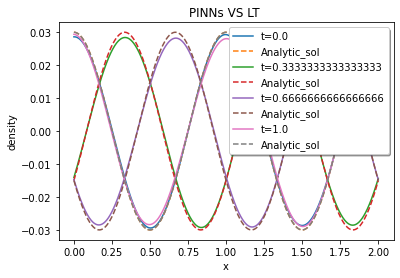

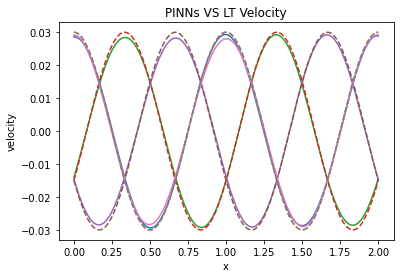

In [6]:
time_array = np.linspace(0,tmax,tmax+3)
# time_array = np.linspace(0,1,4)
plot_function(time_array,velocity=True,isplot =True)
# plot_function(time_array,velocity=True)


Text(0.5, 0.92, 'Time=1')

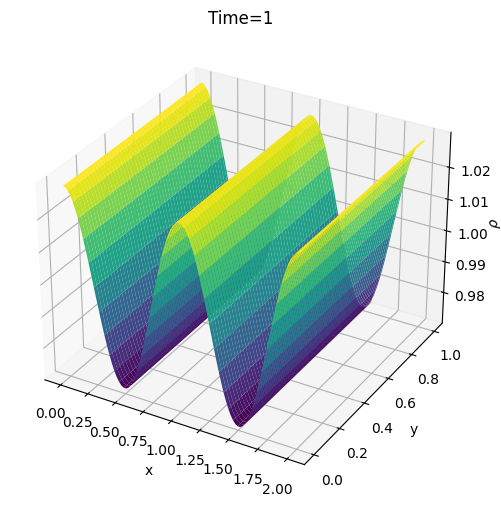

In [7]:
plt.style.use('default')
# for Time in time_array:

Time = tmax
Q = 100
xs = np.linspace(0, xmax, Q)
ys = np.linspace(0, ymax, Q)
tau, phi = np.meshgrid(xs, ys) 
Xgrid = np.vstack([tau.flatten(),phi.flatten()]).T
t_00 = Time*np.ones(Q**2).reshape(Q**2, 1)
X_00 = np.hstack((Xgrid, t_00))

## Output from the Neural Netwrok

output_00 = model.predict(X_00)
rho = output_00[:,0].reshape(Q,Q)
U = output_00[:,1].reshape(Q,Q)
V = output_00[:,2].reshape(Q,Q)
# PHI = output_00[:,3].reshape(Q,Q)

# if ax is None: ## for single plot
#     plt.figure(figsize=(5, 5))
#     ax = plt.gca() 

fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(tau, phi, rho, cmap='viridis')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$\rho$",labelpad=1)
ax.set_title("Time={}".format(round(Time,2)))

    # eq = 0.12 * tau + 0.01 * phi + 1.09
    # ax.plot_surface(tau, phi, eq)
    # fig.colorbar(surf)
    # plt.tight_layout()
    # fig.savefig(output_folder+'/3D-Ins'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=500,bbox_inches = 'tight')


In [8]:
def Two_D_surface_plots(time,ax =None):


    Q = 100
    xs = np.linspace(0, xmax, Q)
    ys = np.linspace(0, ymax, Q)
    tau, phi = np.meshgrid(xs, ys) 
    Xgrid = np.vstack([tau.flatten(),phi.flatten()]).T
    t_00 = Time*np.ones(Q**2).reshape(Q**2, 1)
    X_00 = np.hstack((Xgrid, t_00))
    output_00 = model.predict(X_00)
    rho = output_00[:,0].reshape(Q,Q)
    U = output_00[:,1].reshape(Q,Q)
    V = output_00[:,2].reshape(Q,Q)
#     # plt.streamplot(tau, phi, U, V, density =[0.4, 0.8], arrowstyle ='->',
#                   # arrowsize = 0.5)
#     # plt.quiver(tau, phi, U, V,color='k',headwidth=2.0,headlength=2.0) 

    if ax is None: ## for single plot
        plt.figure(figsize=(5, 5))
        ax = plt.gca() 
    # fig1, ax = plt.subplots()

    pc = ax.pcolormesh(tau, phi, rho, shading='auto',cmap='YlOrBr',vmin=np.min(rho), vmax=np.max(rho)) # YlOrBr
    # pc = ax.contourf(tau, phi, rho, shading='gouraud')
    skip = (slice(None, None, 5), slice(None, None, 5))
    ax.quiver(tau[skip], phi[skip], U[skip], V[skip],color='k',headwidth=3.0,width = 0.003)
    # ax.text(0.30, .9, r" T= {} ".format(round(time,2)), color="w", fontsize=12)
    
    ax.set_title("Time={}".format(round(time,2)))
    # plt.quiver(tau, phi, U, V,rho,color='k',headwidth=3.0,width = 0.003) 
    cbar = plt.colorbar(pc, shrink=0.6, location='bottom')
    cbar.formatter.set_powerlimits((0,0))
    cbar.ax.set_title(r" $\rho$",fontsize = 14)
    # ax.set_xlabel("x")
    # ax.set_ylabel("y",fontsize = 18)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    
#     return pc
    # show plot
    # plt.show()
    
    # return ax
    # fig.savefig(output_folder+'/2D-Ins'+str(lam)+'_'+str(num_of_wave)+'_'+str(tmax)+'.png', dpi=500,bbox_inches = 'tight')

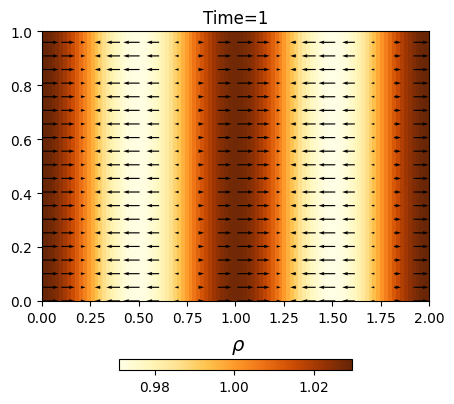

In [9]:
Two_D_surface_plots(1)

# f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharex=False, sharey=True,figsize=(8,4))
# im1 = Two_D_surface_plots(0.1,ax=ax1)
# im2 = Two_D_surface_plots(2,ax=ax2)
# im2 = Two_D_surface_plots(3,ax=ax3)

## To compare with Finite Difference solution

### 1.3 LAX Method

Here the Lax method is used to integrate the flux conservative form of the continuity and momentum equations. For an equation of the form 

$$
\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial x}\left(fv_x\right) - \frac{\partial }{\partial y}\left(fv_y\right)
\end{equation}\tag{6}
$$

the Lax method is the finite-difference approximation in 2D,

$$
\begin{equation}
\frac{f^{n+1}_{i,j}-\left( f^{n}_{i+1,j} + f^{n}_{i-1,j}+f^{n}_{i,j+1} + f^{n}_{i,j-1}\right)/4}{\Delta t}=-\frac{f^{n}_{i+1,j}v^{n}_{x,i+1,j}-f^{n}_{i-1,j}v^{n}_{x,i-1,j}}{2\Delta x} - -\frac{f^{n}_{i,j+1}v^{n}_{y,i,j+1}-f^{n}_{i,j-1}v^{n}_{y,i,j-1}}{2\Delta y}
\end{equation}\tag{7}
$$
Forward Time Centered Space (FTCS) method is unconditionally unstable . But the Lax method is conditionally stable if,

$$
\begin{equation}
\nu \equiv \frac{c\Delta t}{\Delta x} \leq 1
\end{equation}\tag{8}
$$ -->

In [10]:
def fft_solver(rho,Lx,N, dim = None):
    
    '''
    A FFT solver that uses discrete Fast Fourier Transform to
    solve the poisson Equation:
    We apply the correct due to the finite difference grid of phi
    
    Input: 1. The source function density in this case
           2. # of grid point N
           3. Domain Size in each dimension
    
    Output: the potential phi and the field g 
    
    '''
    nx = N
    Lx = Lx
    
    dx = Lx / nx
    
    
    # Calculate the Fourier modes of the gas density
    rhohat = fft(rho)

    # Calculate the wave numbers in x and y directions
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    #ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

    # Construct the Laplacian operator in Fourier space
    kx2 = np.meshgrid(kx**2)
    
#     laplace = -(kx**2 )
    ## Laplace with the correction refer to the notes
    laplace = 2*(np.cos(kx*dx)-1)
    
    ## Inorder to avoid the inf we replace zero with a small number
    laplace[laplace == 0] = 1e-16
    
    # Solve for the gravitationa potential in Fourier space
    phihat = rhohat / laplace
    
    phihat = rhohat * dx**2/laplace
#     window = signal.windows.tukey(len(phihat),alpha=0.25)


    # Transform back to real space to obtain the solution
#     phi = np.real(ifft(phihat*window))
    phi = np.real(ifft(phihat))
    
    ## The field ,i.e., gravity 
    dphidx = np.gradient(phi, dx)

    return phi,dphidx

In [11]:
def lax_solution(time,lam,num_of_waves,rho_1 = rho_1,gravity=False,isplot = None,animation=None):
    # rho_max = []
    lam = lam          # one wavelength
    num_of_waves  = num_of_waves  
    L = xmax            # Maximum length (two wavelength)
    
    # print("at time= ",time)
    ### Declaring the Constants

    c_s = 1.0            # % Sound Speed        
    nu = 0.1            # courant number (\nu = 2 in 2d)
    rho_1 = rho_1        # question 2a linear wave propagation
    const =  1 # 4.0 * np.pi           # The actual value is 4*pi
    G = 1

    ### Grid X-T 
    N = 2000            # The grid resolution values2d:N =(10,50,100,500)
    dx = float(L/N)      # length spacing        
    dt = nu*2*dx         # time grid spacing

    n = int(time/dt)     # grid points in time
    # print("For time grid n = {} ".format(n))
    
    ## Initializing the ARRAY
    x = np.linspace(0, L, N)
    rho = np.zeros((n,N))
    dphidx = np.zeros((n,N))
    phi = np.zeros((n,N))
    v =np.zeros((n,N))  
    P =np.zeros((n,N))
    
#         print(np.shape(rho))

    jeans = np.sqrt(4*np.pi**2*c_s**2/(const*G*rho_o))
    # print("Jean's Length",jeans)

    
    ######################## Initial Conditions ###########################
    rho[0,:] = rho_o + rho_1* np.cos(2*np.pi*x/lam) # defing the density at t = 0
    
    if gravity == False:
        print("Propagation of Sound wave")
        v_1 = (c_s*rho_1)/rho_o # velocity perturbation
        v[0,:] = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0
    else:
        if lam >= jeans:
            print("There is gravitational instabilty  lam = {} > l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(const*G*rho_o-c_s**2*(2*np.pi/lam)**2)
            v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity        
            v[0,:] = - v_1 * np.sin(2*np.pi*x/lam) # the velocity at t =0
            ## density values from Linear Theory at t
            rho_LT = rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam)
            rho_LT_max = np.max(rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam))
#             print("rho_theory_max={} and the max density {} at time {}".format(rho_LT_max ,rho_max, round(time,2)))

        else:
            print("There is no gravitational instabilty as lam = {} < l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(c_s**2*(2*np.pi/lam)**2 - const*G*rho_o)
            v_1 = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) # velocity perturbation
            v[0,:] = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0

        ## Calculating the potential and the field using FFT    
        phi[0,:],dphidx[0,:] = fft_solver(const*(rho[0,:]-rho_o),L,N, dim = None)

    ######### The Flux term #########
    P=rho*v

    #################################FINITE DIFFERENCE #######################
    for k in range(1,n):

        rho[k,:] = 0.5*(np.roll(rho[k-1,:],-1)+ np.roll(rho[k-1,:],1))-(nu*(np.roll(rho[k-1,:],-1)*np.roll(v[k-1,:],-1)-np.roll(rho[k-1,:],1)*np.roll(v[k-1,:],1)))

        if gravity == False:

            P[k,:] = 0.5*(np.roll(P[k-1,:],-1)+ np.roll(P[k-1,:],1))-(nu*(np.roll(P[k-1,:],-1)*np.roll(v[k-1,:],-1)- np.roll(P[k-1,:],1)*np.roll(v[k-1,:],1)))-((c_s**2)*nu*(np.roll(rho[k-1,:],-1)- np.roll(rho[k-1,:],1)))
        else:

            P[k,:] = 0.5*(np.roll(P[k-1,:],-1)+ np.roll(P[k-1,:],1))-(nu*(np.roll(P[k-1,:],-1)*np.roll(v[k-1,:],-1)- np.roll(P[k-1,:],1)*np.roll(v[k-1,:],1)))\
            -((c_s**2)*nu*(np.roll(rho[k-1,:],-1)- np.roll(rho[k-1,:],1))) -(nu*rho[k-1,:]*(np.roll(phi[k-1,:],-1)- np.roll(phi[k-1,:],1)))#  - dt*rho[k-1,:]* dphidx[k-1,:]  #  # np.roll(rho[k-1,:],-1)*np.roll(dphidx[k-1,:],-1)

            phi[k,:],dphidx[k,:] = fft_solver(const*(rho[k,:]-rho_o),L,N, dim = None) ## Please note we don't use dphidx rather calculate using central differencing

    

        v[k,:] = P[k,:]/rho[k,:]
    rho_max = np.max(rho)   
    ################################# PLOTTING #######################
 
    if isplot : 
        plt.figure(1,figsize=(6,4))
        plt.plot(x,rho[n-1,:]-rho_o,linewidth=1,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        # plt.text(.6,.15,r"dt=%f"%(dt),fontsize=12)
        plt.title("At time {} and rho_1 = {}".format(time,rho_1))
        plt.ylabel(r"$\mathbf{\rho - \rho_{0}}$")

        plt.figure(2,figsize=(6,4))
        plt.plot(x,v[n-1,:],'--',markersize=2,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        plt.title(r"Lax Solution Velocity For $\rho_1$ = {}".format(rho_1))
        plt.ylabel("velocity")

        if gravity:
             #### Plotting the comparison of the \rho_max for FD and Linear Theory 
            
            plt.figure(3,figsize=(6,4))                                
            plt.scatter(time,rho_max)
            plt.scatter(time,rho_LT_max,facecolors='none', edgecolors='r',label="LT")           
            plt.xlabel("t")
            plt.ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
            plt.yscale('log')
            plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)

            ## Plotting the gravitational potential (\phi) and field (g)
            plt.figure(4,figsize=(6,4))
            plt.plot(x,phi[n-1,:],'--',markersize=2,label="t=phi at {}".format(round(time,2)))
#                 plt.plot(x,dphidx[n-1,:],'--',markersize=2,label="g at t={}".format(time))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$\Phi$")

            plt.figure(5,figsize=(6,4))
#                 plt.plot(x,phi[n-1,:],'--',markersize=2,label="t=phi at {}".format(time))
            plt.plot(x,dphidx[n-1,:],'--',markersize=2,label="g at t={}".format(round(time,2)))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$g$")

    else:
        if gravity:
            return x,rho,v,phi,dphidx,n,rho_LT,rho_LT_max,rho_max
        else:
            return x,rho,v,n
            
    ## Clearing the memory
    del rho, dphidx, phi, v, P

Propagation of Sound wave
Propagation of Sound wave


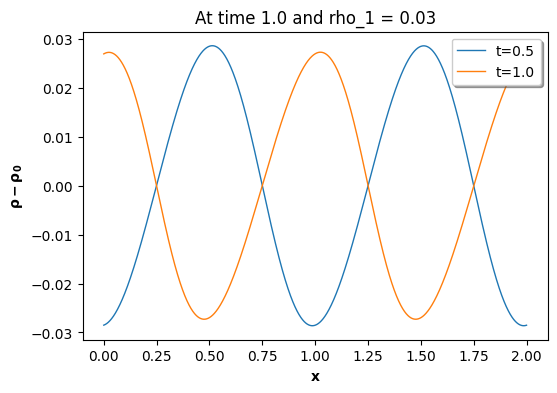

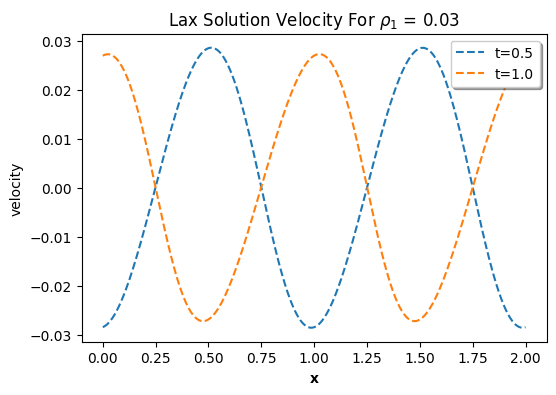

In [12]:
time_array = [0.5,1.0] 
for time in time_array:
    lax_solution(time,lam,num_of_waves,rho_1,isplot=True)

Plotting at t= 0.3
Testing the code at t=0.3 
Propagation of Sound wave


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting at t= 0.6
Testing the code at t=0.6 
Propagation of Sound wave


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting at t= 0.9
Testing the code at t=0.9 
Propagation of Sound wave


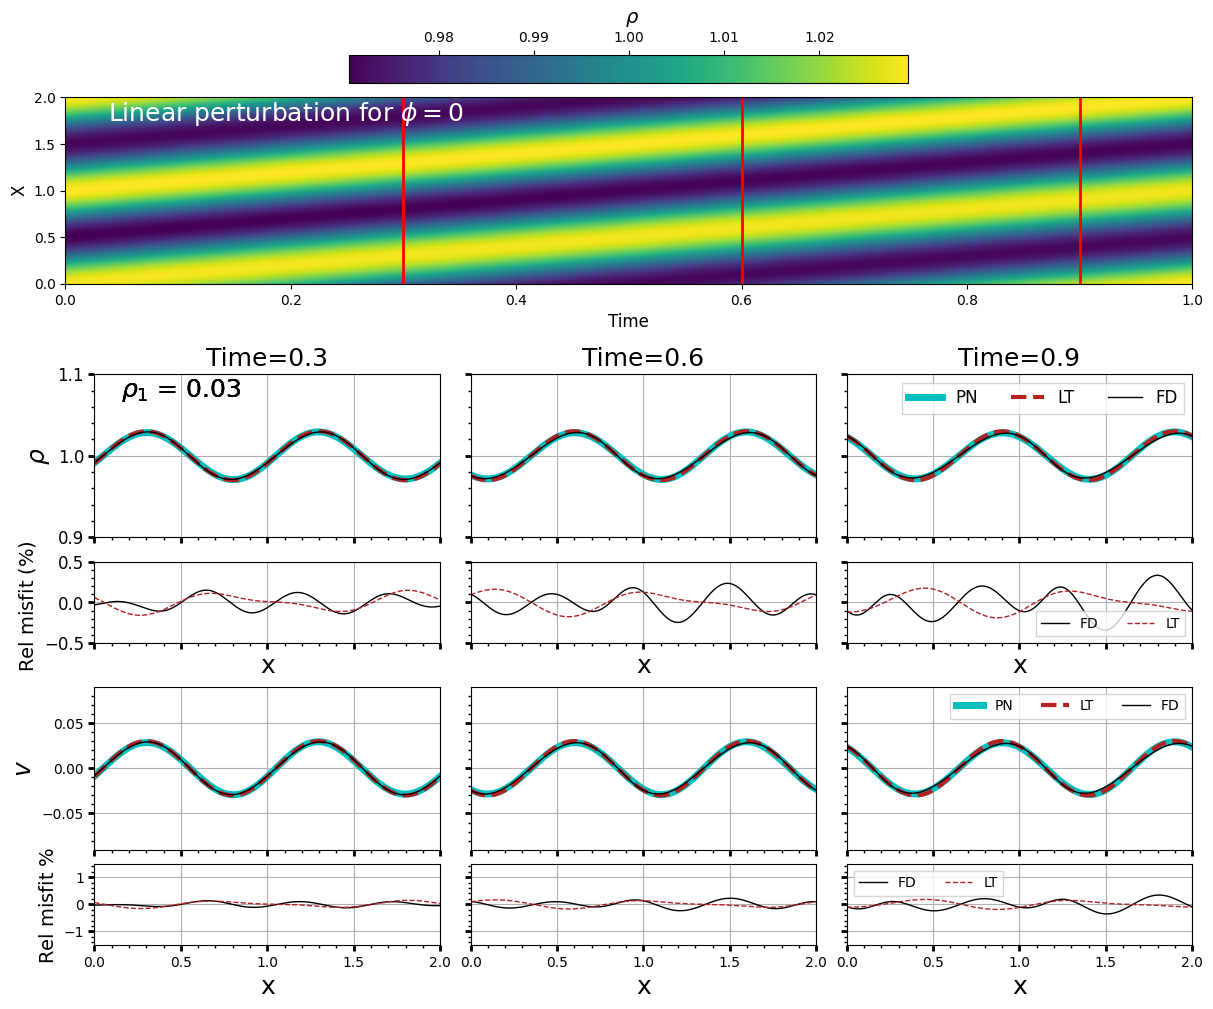

In [13]:
time_array = np.asarray([0.3,0.6,0.9])
plt.style.use('default')
def example_plot(ax, fontsize=12, hide_labels=False):
    Q=1000    
    X, T = np.meshgrid(np.linspace(xmin,xmax,Q), np.linspace(0,tmax,Q))
    y_slice = ycut*np.ones(Q**2).reshape(Q**2, 1)
    X_star = np.hstack((X.flatten()[:,None],y_slice.flatten()[:,None], T.flatten()[:,None]))
    
    output_0 = model.predict(X_star)
    rho_pred0 = output_0[:,0:1]
    Z = rho_pred0.reshape(Q,Q)
    pc = ax.pcolormesh(T,X,Z, shading='auto')
    
    if not hide_labels:
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel('X', fontsize=fontsize)
        ax.set_title('', fontsize=fontsize)
    return pc

np.random.seed(19680808)
# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(12, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[1.5,3])

axsLeft = subfigs[0].subplots(1, 1, sharey=False)
axsLeft.set_ylim(xmin,xmax)
axsLeft.set_xlim(0,tmax)
# subfigs[0].set_facecolor('0.75')
pc = example_plot(axsLeft)
# subfigs[0].suptitle('Left plots', fontsize='x-large')
axsLeft.text(0.038, 1.75, r"Linear perturbation for $\phi =0$ ", color="w", fontsize=18)

cbar = subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='top')
cbar.formatter.set_powerlimits((0,0))
cbar.ax.set_title(r" $\rho$",fontsize = 14)

axes = subfigs[1].subplots(4, 3,sharex=True,  sharey='row',gridspec_kw={'width_ratios':[1,1,1], 'height_ratios':[3,1.5,3,1.5]})
for time,j in zip(time_array,(range(len(axes[0])))):
    axsLeft.axvline(x=time, linewidth=2,color='r')
    X,rho_pred0,v_pred0,rho_LT,v_LT = plot_function(time,velocity=False,isplot=False,animation= True)
    x,rho,v,n = lax_solution(time,lam,num_of_waves,rho_1,isplot=False,animation= True)
    
    axes[0][j].plot(X,rho_pred0,color='c',linewidth=5,label="PN")    
    # axes[0][j].plot(x,rho[n-1,:],marker='o',markersize=4,color = 'green',label="FD")
    axes[0][j].plot(X,rho_LT,linestyle='dashed',color ='firebrick',linewidth=3,label="LT")
    axes[0][j].plot(x,rho[n-1,:],linestyle='solid',color = 'black',linewidth=1.0,label="FD")
    axes[0][j].set_title("Time={}".format(round(time,2)),fontsize = 18)
    axes[0][0].set_ylabel(r"$\rho$",fontsize = 18)
    axes[0][j].set_ylim(0.90,1.1)
    axes[0][j].set_xlim(xmin,xmax)

    ## To plot the velocity

    # ax.plot(x,v[n-1,:],color='yellow',linewidth=2,label="FD")
    # ax.plot(X,v_pred0,'k',label="PN")
    # ax.plot(X,v_LT,'--',linewidth=1,label="LT")
    # ax.set_title("t={}".format(round(time,2)))
    # ax.set_ylabel(r"$v$")

    ## Axes settings
#     axes[0][j].set_xlabel("x",fontsize = 18)
    axes[0][j].grid("True")
    axes[0][j].minorticks_on()
    axes[0][j].tick_params(labelsize=12)
    axes[0][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[0][j].tick_params(axis='both', which='minor',length=2, width=1)
    axes[0][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 12)
    axes[0][0].text(0.25, 0.9, r"$\rho_1$ = {}".format(rho_1),fontsize = 18, horizontalalignment='center', verticalalignment='center', transform=axes[0][0].transAxes) 


    axes[1][j].plot(x,(rho_pred0[:,0]- rho[n-1,:])/((rho_pred0[:,0]+ rho[n-1,:])/2)*100,color = 'black',linewidth=1,label="FD")
    axes[1][j].plot(x,(rho_pred0.flatten()-rho_LT.flatten())/((rho_pred0.flatten()+ rho_LT.flatten())/2)*100,color = 'firebrick',linestyle='dashed',linewidth=1,label="LT")
    axes[1][j].set_xlabel("x",fontsize = 18)
    axes[1][j].grid("True")
    axes[1][j].minorticks_on()
    axes[1][j].tick_params(labelsize=12)
    axes[1][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[1][j].tick_params(axis='both', which='minor',length=2, width=1.)
    axes[1][0].set_ylabel(r"Rel misfit ($\%$)  ",fontsize = 14)
    axes[1][j].set_ylim(-.5,.5)
    axes[1][j].set_xlim(xmin,xmax)
    axes[1][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    
#      ### VELOCITY PART ######
   
    axes[2][j].plot(X,v_pred0,color='c',linewidth=5,label="PN")    
    axes[2][j].plot(X,v_LT,linestyle='dashed',color ='firebrick',linewidth=3,label="LT")
    axes[2][j].plot(x,v[n-1,:],linestyle='solid',color = 'black',linewidth=1.0,label="FD")
    
    
    # axes[3][j].set_title("Time={}".format(round(time,2)))
    axes[2][0].set_ylabel(r"$v$",fontsize = 18)
    # axes[0][j].set_xlabel("x",fontsize = 18)
    axes[2][j].grid("True")
    axes[2][j].minorticks_on()
    axes[2][j].tick_params(labelsize=10)
    axes[2][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[2][j].tick_params(axis='both', which='minor',length=2, width=1)
    # limu = 1.15*v_o
    # liml = .85*v_o
    # axes[0][j].set_ylim(liml,limu)
    axes[2][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[2][0].text(0.44, 0.9, r"$\rho_1$ = {}, $\lambda$ = {} $\lambda_J$ ".format(rho_1,round(lam/(2*np.pi),2)),fontsize = 15, horizontalalignment='center', verticalalignment='center', transform=axes[0][0].transAxes)
    axes[2][j].set_xlim(xmin,xmax)
    axes[2][j].set_ylim(-0.09,0.09)
    
    
    axes[3][j].plot(x,(v_pred0[:,0]+1- (v[n-1,:]+1))/((v_pred0[:,0]+1+ v[n-1,:]+1)/2)*100,color = 'black',linewidth=1,label="FD")
    axes[3][j].plot(x,(v_pred0.flatten()+1-(v_LT.flatten()+1))/((v_pred0.flatten()+2+ v_LT.flatten())/2)*100,color = 'firebrick',linestyle='dashed',linewidth=1,label="LT")
    # axes[1][j].plot(x,(rho_pred0[:,0]- rho[n-1,:])/((rho_pred0[:,0]+ rho[n-1,:])/2)*100,color = 'k',linewidth=1,label="FD")
    # axes[1][j].plot(x,(rho_pred0[:,0]-rho_LT)/((rho_pred0[:,0]+ rho_LT)/2)*100,color = 'b',linewidth=1,label="LT")
    axes[3][j].set_xlabel("x",fontsize = 18)
    axes[3][j].grid("True")
    axes[3][j].minorticks_on()
    axes[3][j].tick_params(labelsize=10)
    axes[3][j].tick_params(axis='both', which='major',length=4, width=2)
    axes[3][j].tick_params(axis='both', which='minor',length=2, width=1.)
    axes[3][2].legend(loc='best',fancybox=False, shadow=False, ncol=3,fontsize = 10)
    # axes[1][0].set_ylabel(r"$\rho_{PN}- \rho_{FD or LT}/(0.5 (\times\rho_{PN}+ \rho_{FD or LT}))$",fontsize = 10)
    axes[3][0].set_ylabel(r"Rel misfit $\%$ ",fontsize = 14)
    axes[3][j].set_ylim(-1.5,1.5)
    axes[3][j].set_xlim(xmin,xmax)
    
    
    
plt.savefig(output_folder+'/complete'+str(lam)+'_'+str(num_of_waves)+'_'+str(tmax)+'.png', dpi=500,bbox_inches = 'tight')

## Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as anim
from IPython.display import HTML
from pathlib import Path

from matplotlib import animation, rc
from IPython.display import HTML, Image # For GIF

rc('animation', html='html5')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# import matplotlib.animation as animation
import matplotlib.animation as anim
# plt.style.use('ggplot')
plt.style.use('default')
## Time and Space Array
N  = 100
t = np.linspace(0,tmax,100)
# X = np.linspace(xmin,xmax,N).reshape(N, 1)
numDataPoints = len(t)

xs = np.linspace(xmin, xmax, N)
ys = np.linspace(ymin, ymax, N)
tau, phi = np.meshgrid(xs, ys) 
Xgrid = np.vstack([tau.flatten(),phi.flatten()]).T
print(np.shape(Xgrid))

def animate_func(num):
    fig.clear()
    # ax.clear()  # Clears the figure to update the line, point,   
    # ax2.clear()  
    # ax3.clear()  # Clears the figure to update the line, point
    # ax4.clear()  # Clears the figure to update the line, point
    
    t_ = t[num+1]*np.ones(N*N).reshape(N*N, 1)
    # t0 = t[0]*np.ones(1000).reshape(1000, 1)
    print(np.shape(t_))
    # X_0 = np.hstack((Xgrid, t_00))
    # output_00 = model.predict(X_00)
    # test = output_00[:,0].reshape(20,20)
    X_0 = np.hstack((Xgrid, t_))
    # X_intial = np.hstack((X,t0))
    # intial_output = model.predict(X_intial)
    output_0 = model.predict(X_0)
    rho_pred0 = output_0[:,0].reshape(N,N)
    # v_pred0 = output_0[:, 1:2]
    # phi_pred0=output_0[:, 2:3]

    ax = fig.add_subplot(111, projection='3d')
    ax.axes.set_zlim3d(bottom=0.95, top=1.05)
    surf = ax.plot_surface(tau, phi, rho_pred0 , cmap='viridis')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(r"$\rho$",labelpad=1)
    ax.set_title("Time={}".format(round(t[num+1],2)))
    # fig.colorbar(surf, shrink=0.5, aspect=5)

    # plt.title(r"Pinns Solution for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
    plt.tight_layout()



line_ani = FuncAnimation(fig, animate_func, interval=30,   
                                   frames=numDataPoints-1)
# # converting to an html5 video
# video = line_ani.to_html5_video()
  
# # embedding for the video
# html = display.HTML(video)
  
# # draw the animation
# display.display(html)
# saving to m4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=20)
# line_ani.save('3Dinstability_'+str(lam)+ '.mp4', writer=writervideo)
# ax4.clear()  # Clears the figure to update the line, point
line_ani.save(output_folder+'/2Dwave_'+str(lam)+ '.gif', writer='pillow', fps=60)
plt.close()
plt.show()


(10000, 2)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
